<a href="https://colab.research.google.com/github/divya-r-kamat/EfficientMnist-Under20K/blob/main/EfficientMnistNN_Iter6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## MNist Neural Network

The goal is to achieve 99.4% validation/test accuracy, with less than 20k Parameters and in 20 epochs | 13.5k Parameters | GAP Layer

### Import Libraries

In [10]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary
import matplotlib.pyplot as plt

### Model Architecture

In [11]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3)    # RF = 3
        self.bn1 = nn.BatchNorm2d(8)

        self.conv2 = nn.Conv2d(8, 16, kernel_size=3)   # RF = 5
        self.bn2 = nn.BatchNorm2d(16)

        self.conv3 = nn.Conv2d(16, 28, kernel_size=3)  # RF = 7
        self.bn3 = nn.BatchNorm2d(28)

        self.conv4 = nn.Conv2d(28, 8, kernel_size=1)   # RF = 7
        self.bn4 = nn.BatchNorm2d(8)

        # MaxPool2d will follow conv4 in forward() → RF = 8, jump = 2

        self.conv5 = nn.Conv2d(8, 16, kernel_size=3)   # RF = 12
        self.bn5 = nn.BatchNorm2d(16)

        self.conv6 = nn.Conv2d(16, 16, kernel_size=3)  # RF = 16
        self.bn6 = nn.BatchNorm2d(16)

        self.conv7 = nn.Conv2d(16, 28, kernel_size=3)  # RF = 20

        # GAP will reduce [B, 28, H, W] → [B, 28, 1, 1]
        self.gap = nn.AdaptiveAvgPool2d(1)

        # Classifier just maps 28 → 10
        self.fc = nn.Linear(28, 10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))  # RF = 3
        x = F.relu(self.bn2(self.conv2(x)))  # RF = 5
        x = F.relu(self.bn3(self.conv3(x)))  # RF = 7

        x = F.max_pool2d(F.relu(self.bn4(self.conv4(x))), 2)  # RF = 8

        x = F.relu(self.bn5(self.conv5(x)))  # RF = 12
        x = F.relu(self.bn6(self.conv6(x)))  # RF = 16
        x = F.relu(self.conv7(x))            # RF = 20

        x = self.gap(x)                      # [B, 28, 1, 1]
        x = x.view(x.size(0), -1)            # [B, 28]

        x = self.fc(x)                       # [B, 10]

        return F.log_softmax(x, dim=1)

### Check if CUDA is available and display model parameters


In [12]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              80
       BatchNorm2d-2            [-1, 8, 26, 26]              16
            Conv2d-3           [-1, 16, 24, 24]           1,168
       BatchNorm2d-4           [-1, 16, 24, 24]              32
            Conv2d-5           [-1, 28, 22, 22]           4,060
       BatchNorm2d-6           [-1, 28, 22, 22]              56
            Conv2d-7            [-1, 8, 22, 22]             232
       BatchNorm2d-8            [-1, 8, 22, 22]              16
            Conv2d-9             [-1, 16, 9, 9]           1,168
      BatchNorm2d-10             [-1, 16, 9, 9]              32
           Conv2d-11             [-1, 16, 7, 7]           2,320
      BatchNorm2d-12             [-1, 16, 7, 7]              32
           Conv2d-13             [-1, 28, 5, 5]           4,060
AdaptiveAvgPool2d-14             [-1, 2

### Print model architecture

In [13]:
print(model)

Net(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(16, 28, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(28, 8, kernel_size=(1, 1), stride=(1, 1))
  (bn4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (bn5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (bn6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv7): Conv2d(16, 28, kernel_size=(3, 3), stride=(1, 1))
  (gap): AdaptiveAvgPool2d(output_size=1)

### Load train and test data, and apply transformations

In [14]:
torch.manual_seed(1)
batch_size = 128
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                    transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
                    transforms.Resize((28, 28)),
                    transforms.RandomRotation((-15., 15.), fill=0),
                    transforms.ToTensor(),
                    transforms.Normalize((0.1307,), (0.3081,)),
                    ])),batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


In [15]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

### Training Loop

In [16]:
from tqdm import tqdm
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    loss = 0
    correct = 0
    processed = 0
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        pbar.set_description(desc= f'Train loss={loss.item():0.4f} batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)
    train_losses.append(loss/len(train_loader))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

### Model training

In [17]:

model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)
num_epochs = 20

for epoch in range(1, num_epochs+1):
    print(f'Epoch {epoch}')
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()

Epoch 1


Train loss=0.1886 batch_id=468 Accuracy=86.58: 100%|██████████| 469/469 [00:26<00:00, 17.54it/s]


Test set: Average loss: 0.0850, Accuracy: 9762/10000 (97.62%)

Epoch 2


Train loss=0.0814 batch_id=468 Accuracy=97.25: 100%|██████████| 469/469 [00:24<00:00, 18.84it/s]


Test set: Average loss: 0.0494, Accuracy: 9827/10000 (98.27%)

Epoch 3


Train loss=0.1380 batch_id=468 Accuracy=97.78: 100%|██████████| 469/469 [00:23<00:00, 19.72it/s]


Test set: Average loss: 0.0412, Accuracy: 9864/10000 (98.64%)

Epoch 4


Train loss=0.0752 batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:23<00:00, 19.98it/s]


Test set: Average loss: 0.0347, Accuracy: 9886/10000 (98.86%)

Epoch 5


Train loss=0.0485 batch_id=468 Accuracy=98.20: 100%|██████████| 469/469 [00:23<00:00, 19.87it/s]


Test set: Average loss: 0.0281, Accuracy: 9917/10000 (99.17%)

Epoch 6


Train loss=0.0138 batch_id=468 Accuracy=98.40: 100%|██████████| 469/469 [00:23<00:00, 20.00it/s]


Test set: Average loss: 0.0266, Accuracy: 9916/10000 (99.16%)

Epoch 7


Train loss=0.1033 batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:23<00:00, 19.99it/s]


Test set: Average loss: 0.0245, Accuracy: 9914/10000 (99.14%)

Epoch 8


Train loss=0.0073 batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:23<00:00, 20.00it/s]


Test set: Average loss: 0.0267, Accuracy: 9911/10000 (99.11%)

Epoch 9


Train loss=0.0744 batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:23<00:00, 20.01it/s]


Test set: Average loss: 0.0306, Accuracy: 9904/10000 (99.04%)

Epoch 10


Train loss=0.0098 batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:23<00:00, 19.98it/s]


Test set: Average loss: 0.0253, Accuracy: 9921/10000 (99.21%)

Epoch 11


Train loss=0.0081 batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:23<00:00, 20.04it/s]


Test set: Average loss: 0.0219, Accuracy: 9930/10000 (99.30%)

Epoch 12


Train loss=0.0255 batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:22<00:00, 20.57it/s]


Test set: Average loss: 0.0268, Accuracy: 9914/10000 (99.14%)

Epoch 13


Train loss=0.0142 batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:23<00:00, 20.30it/s]


Test set: Average loss: 0.0193, Accuracy: 9933/10000 (99.33%)

Epoch 14


Train loss=0.0138 batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:23<00:00, 20.07it/s]


Test set: Average loss: 0.0195, Accuracy: 9939/10000 (99.39%)

Epoch 15


Train loss=0.1371 batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:23<00:00, 20.12it/s]


Test set: Average loss: 0.0220, Accuracy: 9930/10000 (99.30%)

Epoch 16


Train loss=0.0163 batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:23<00:00, 19.96it/s]


Test set: Average loss: 0.0155, Accuracy: 9952/10000 (99.52%)

Epoch 17


Train loss=0.0073 batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:23<00:00, 19.96it/s]


Test set: Average loss: 0.0153, Accuracy: 9952/10000 (99.52%)

Epoch 18


Train loss=0.0911 batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:23<00:00, 19.85it/s]


Test set: Average loss: 0.0151, Accuracy: 9950/10000 (99.50%)

Epoch 19


Train loss=0.0104 batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:23<00:00, 19.98it/s]


Test set: Average loss: 0.0146, Accuracy: 9953/10000 (99.53%)

Epoch 20


Train loss=0.0068 batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:23<00:00, 19.99it/s]


Test set: Average loss: 0.0149, Accuracy: 9950/10000 (99.50%)



### Plots

Text(0.5, 1.0, 'Test Accuracy')

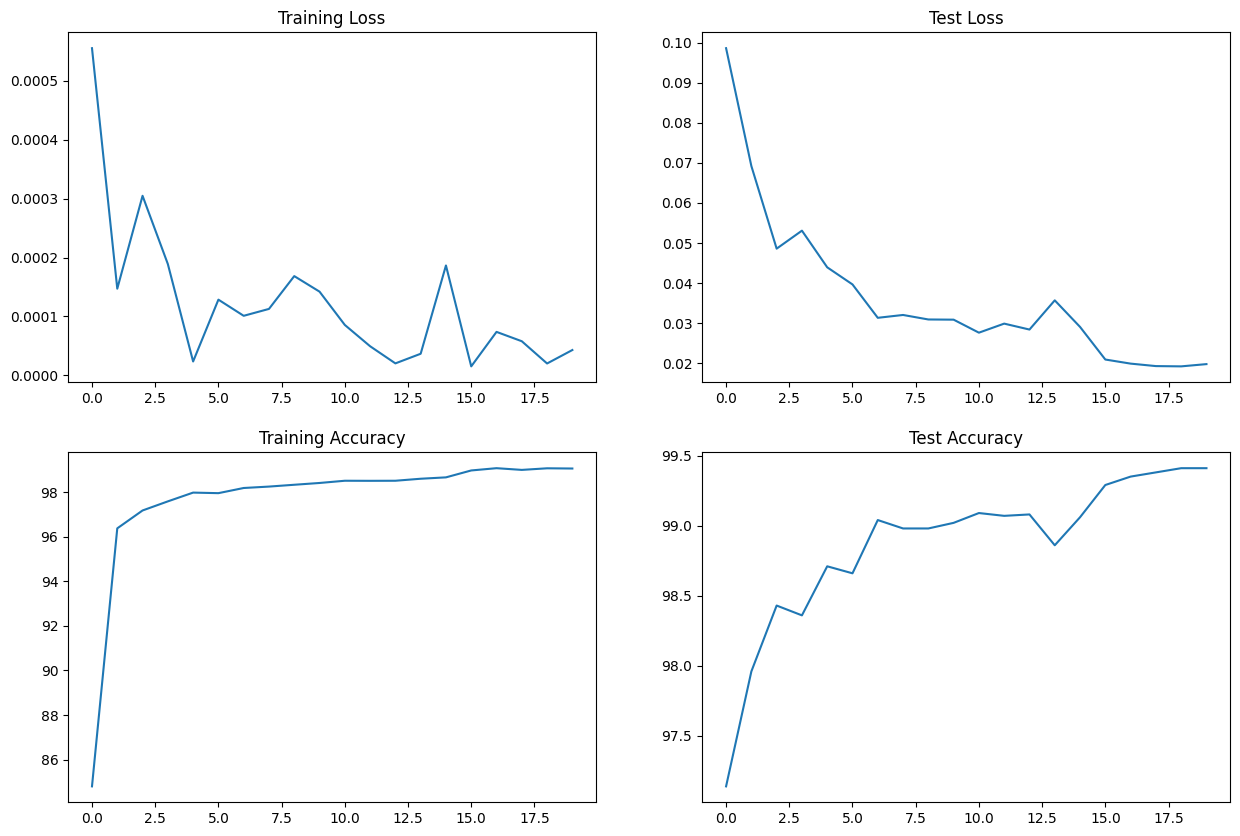

In [9]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot([loss.cpu().item() for loss in train_losses])
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")